In [1]:
import os
import uuid
import torch
import wandb
import argparse
import logging
import datetime
import warnings
import numpy as np
from data import *
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataclasses import dataclass, asdict

from model_io import load_model, save_model

from data import load_from_path, prepare_adv_diff_dataset, AdvectionDiffussionDataset, get_train_val_test_folds, IntervalSplit, exact_solution

# We we define all our model here:
from new_model import Encoder, Decoder, Propagator_concat as Propagator, Model, loss_function

In [2]:
warnings.filterwarnings("ignore")
data_path = "./data"
model_path = "./FlexiPropagator_2D_2025-01-30-12-11-01_0aee8fb0_best.pt"

dataset_train, dataset_val, alpha_interval_split, tau_interval_split = load_from_path(data_path)
state_dict = torch.load(model_path)

In [3]:
def get_model(latent_dim):
    # Instantiate encoder, decoder, and model
    encoder = Encoder(latent_dim)
    decoder  = Decoder(latent_dim)  # Decoder for x(t)
    propagator = Propagator(latent_dim) # z(t) --> z(t+tau)
    model = Model(encoder, decoder, propagator)
    return model

In [4]:
model = get_model(3)
model, alpha_interval_split, tau_interval_split, config = load_model(model_path, model)

In [5]:
# Interval Split
print("Alpha Interval Split", alpha_interval_split)
print()
print("Tau Interval Split", tau_interval_split)

Alpha Interval Split IntervalSplit(interpolation=[2.0912836827924193, 2.991283682792419], extrapolation_left=[1, 1.9], extrapolation_right=[9.1, 10])

Tau Interval Split IntervalSplit(interpolation=[364.7271430702939, 392.2271430702939], extrapolation_left=[150, 177.5], extrapolation_right=[397.5, 425])


# Validating the model

In [6]:
## For the validation data:
X_val, X_tau_val, t_values_val, tau_values_val, alpha_values_val = dataset_val.X, dataset_val.X_tau, dataset_val.t_values, dataset_val.tau_values, dataset_val.alpha_values

In [7]:
print(X_val.shape)

(10800, 128, 128)


In [8]:
dt = 2/500
model = model.cuda()

### Alpha -> Left Extrapolation;  Tau -> Left Extrapolation

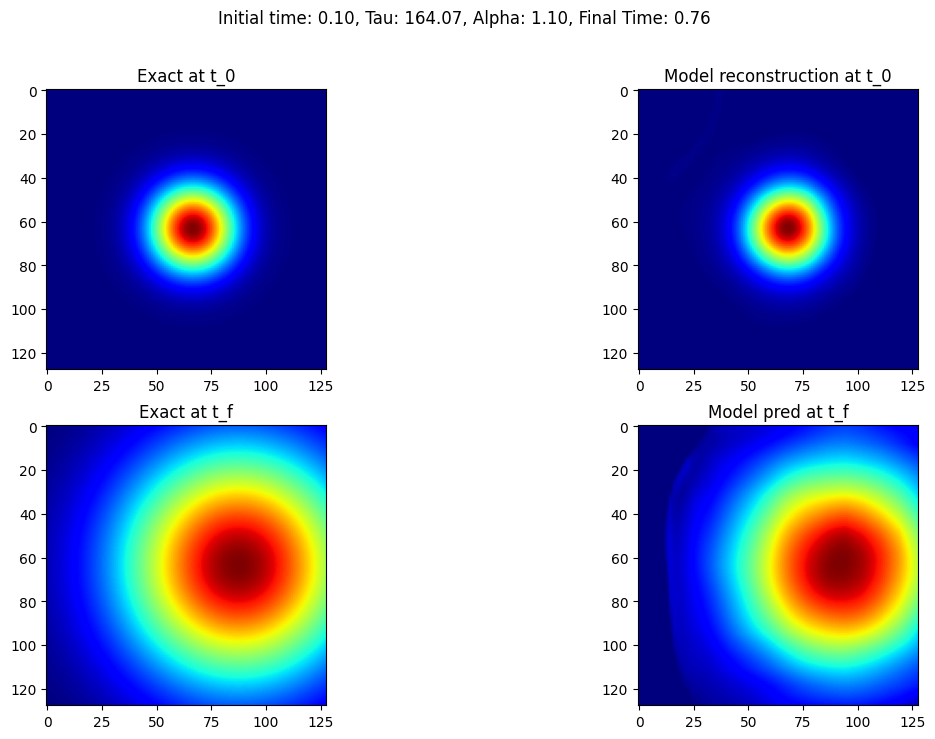

In [9]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_LE = np.random.uniform(*alpha_interval_split.extrapolation_left)
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_LE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_LE, t_0+tau_LE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_LE:.2f}, Alpha: {alpha_LE:.2f}, Final Time: {t_0 + tau_LE*dt:.2f}");

### Alpha -> Left Extrapolation;  Tau -> Interpolation

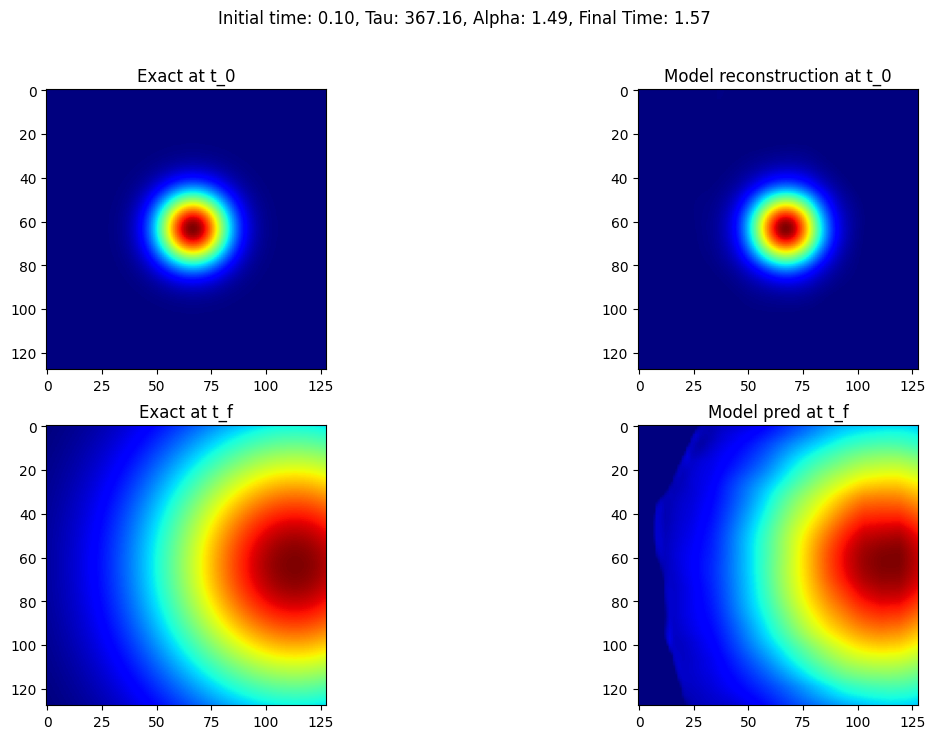

In [10]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_LE = np.random.uniform(*alpha_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_LE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_LE, t_0+tau_Interp*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_Interp:.2f}, Alpha: {alpha_LE:.2f}, Final Time: {t_0 + tau_Interp*dt:.2f}");

### Alpha -> Left Extrapolation;  Tau -> Right Exterp

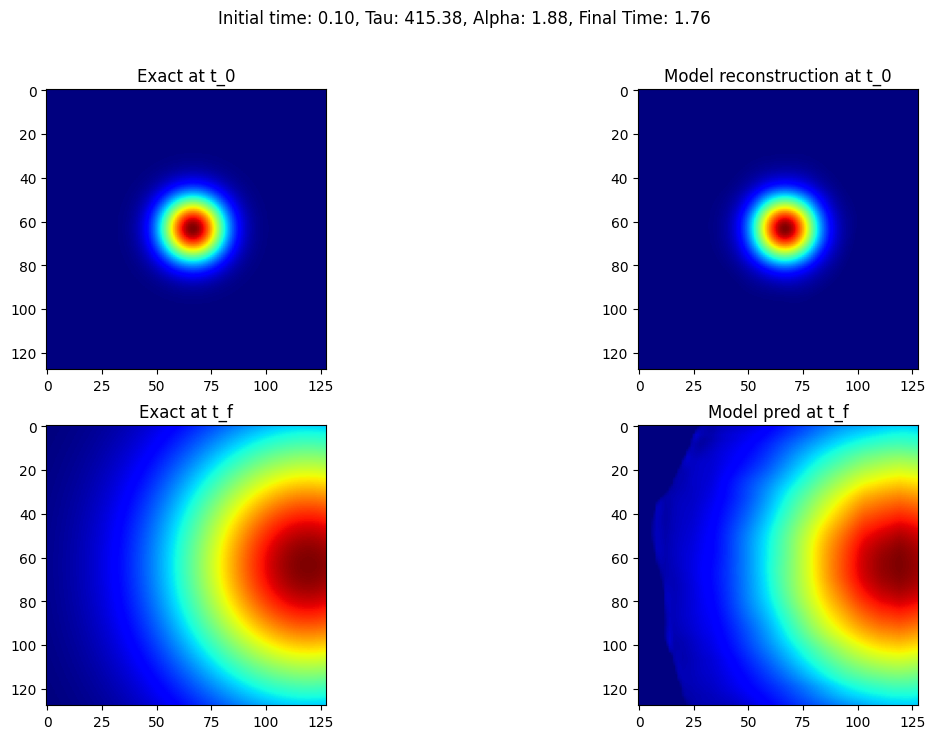

In [11]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_LE = np.random.uniform(*alpha_interval_split.extrapolation_left)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_LE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_LE, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_RE:.2f}, Alpha: {alpha_LE:.2f}, Final Time: {t_0 + tau_RE*dt:.2f}");

### alpha -> Interpolation;  tau -> Left Exterp

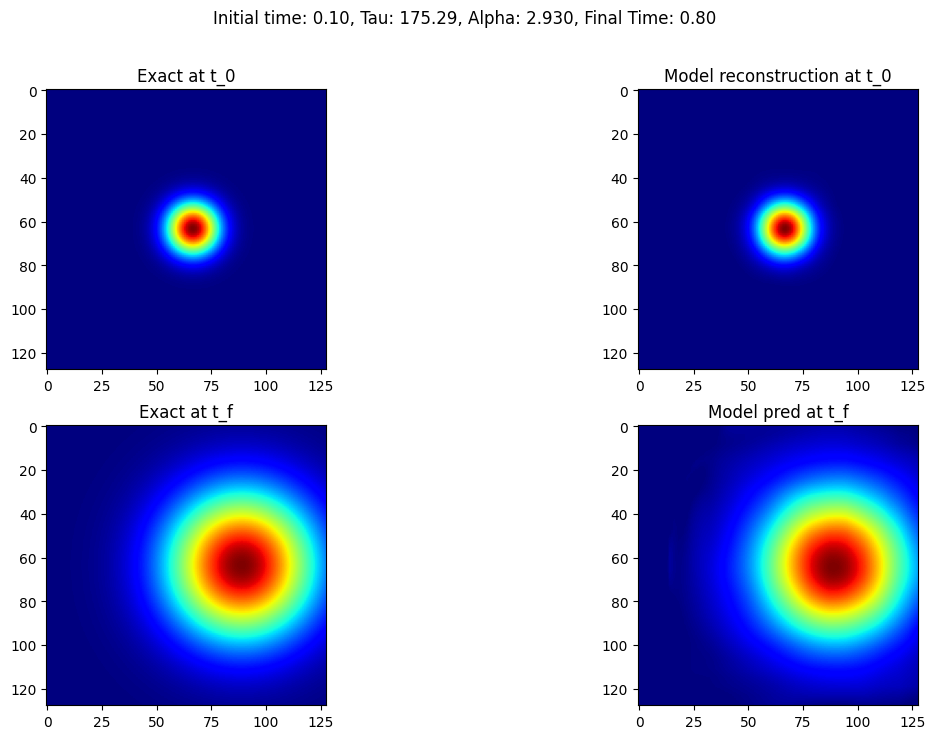

In [12]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_Interp = np.random.uniform(*alpha_interval_split.interpolation)
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_Interp, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_Interp, t_0+tau_LE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_LE:.2f}, Alpha: {alpha_Interp:.3f}, Final Time: {t_0 + tau_LE*dt:.2f}");

### alpha -> Interpolation;  tau -> Interpolation

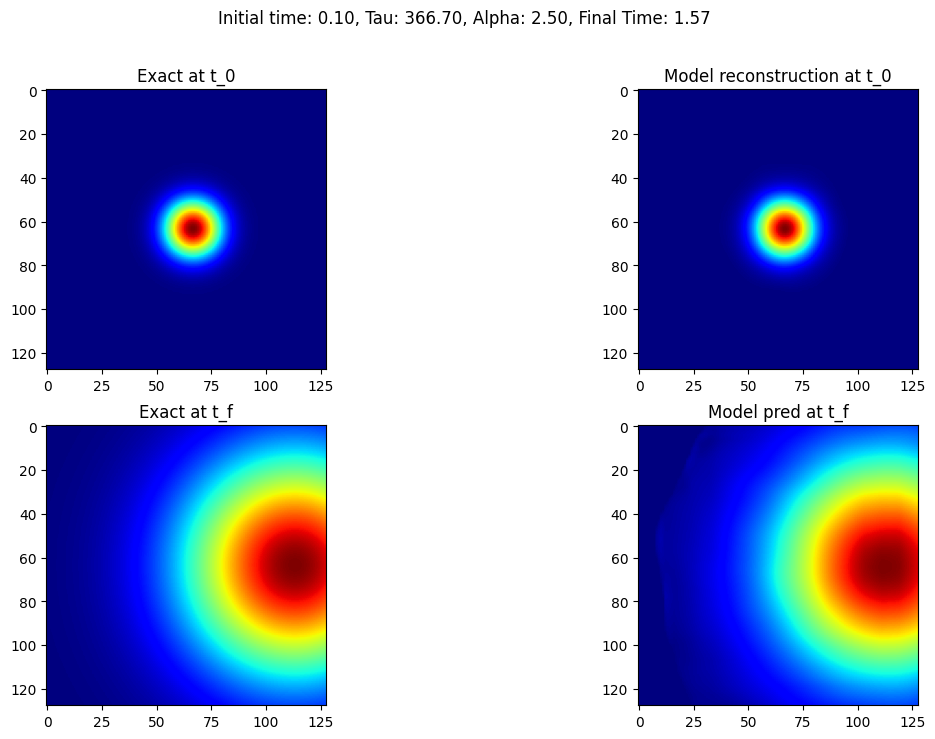

In [13]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_Interp = np.random.uniform(*alpha_interval_split.interpolation)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_Interp, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_Interp, t_0+tau_Interp*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_Interp:.2f}, Alpha: {alpha_Interp:.2f}, Final Time: {t_0 + tau_Interp*dt:.2f}");

### alpha -> Interpolation;  tau -> Right Exterp

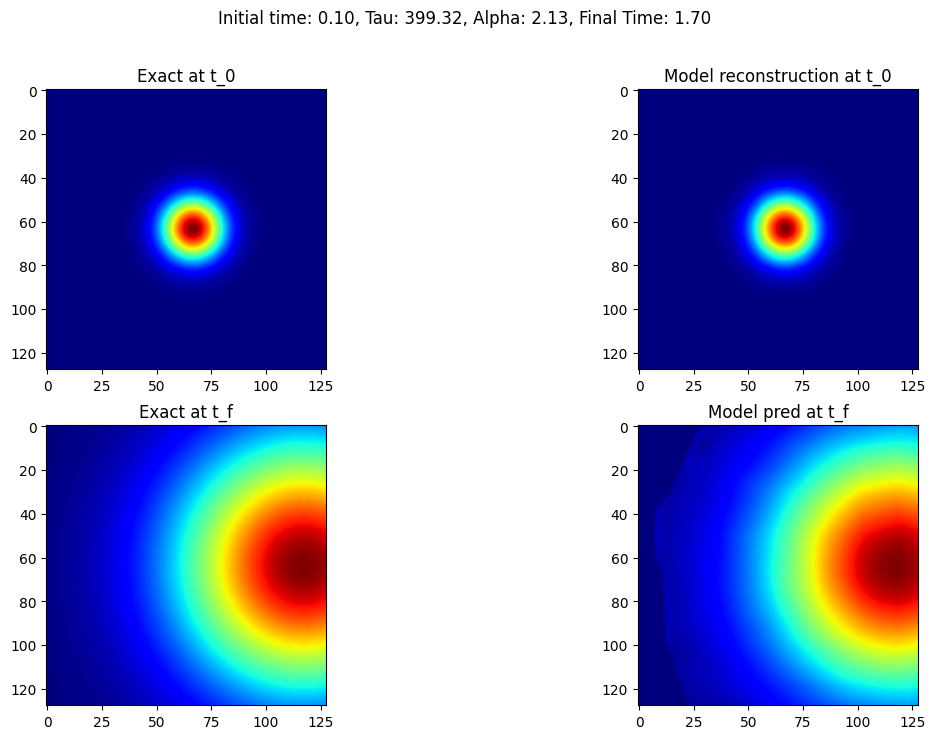

In [14]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_Interp = np.random.uniform(*alpha_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_Interp, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_Interp, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_RE:.2f}, Alpha: {alpha_Interp:.2f}, Final Time: {t_0 + tau_RE*dt:.2f}");

### alpha -> RE;  tau -> Left Exterp

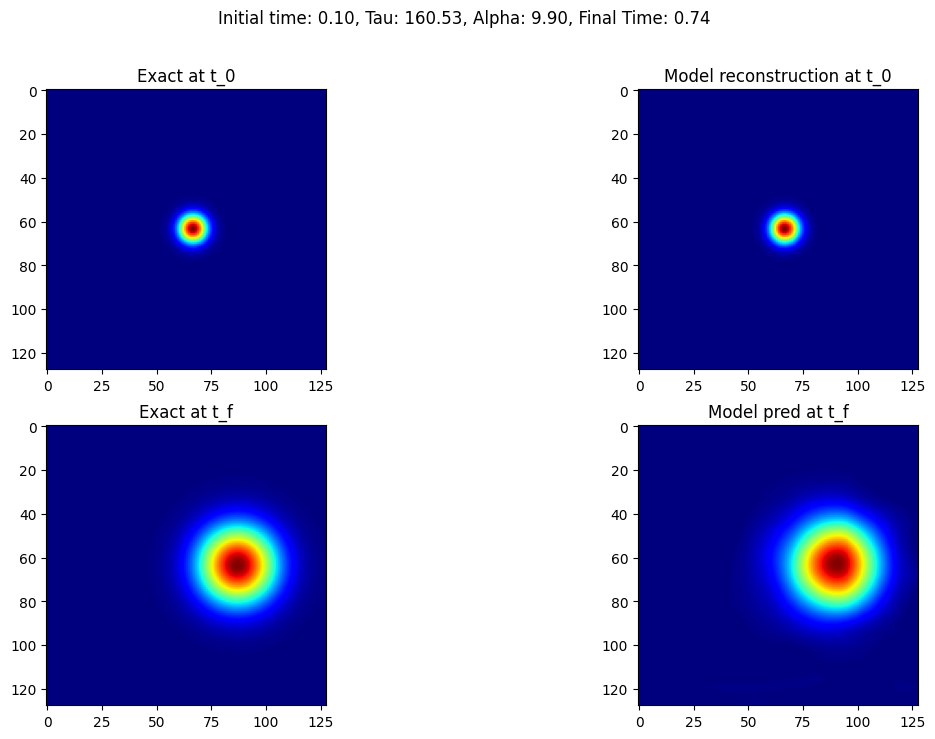

In [15]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_RE = np.random.uniform(*alpha_interval_split.extrapolation_right)
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_RE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_RE, t_0+tau_LE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_LE:.2f}, Alpha: {alpha_RE:.2f}, Final Time: {t_0 + tau_LE*dt:.2f}");

### alpha -> RE;  tau -> Interpolation

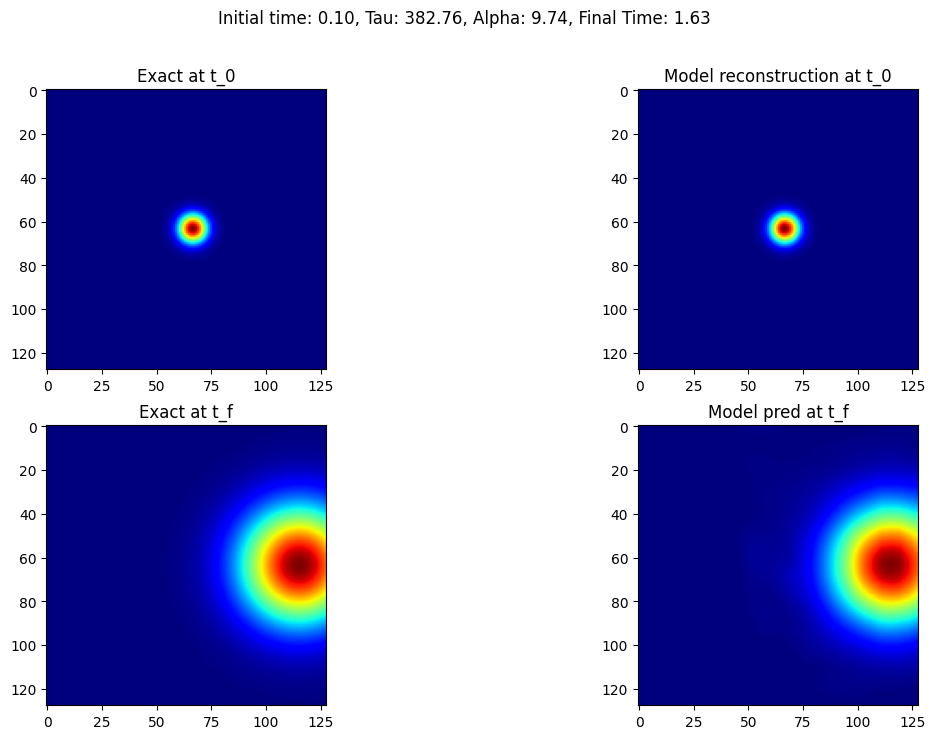

In [16]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_RE = np.random.uniform(*alpha_interval_split.extrapolation_right)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_RE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_RE, t_0+tau_Interp*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_Interp:.2f}, Alpha: {alpha_RE:.2f}, Final Time: {t_0 + tau_Interp*dt:.2f}");

### alpha -> RE;  tau -> RE

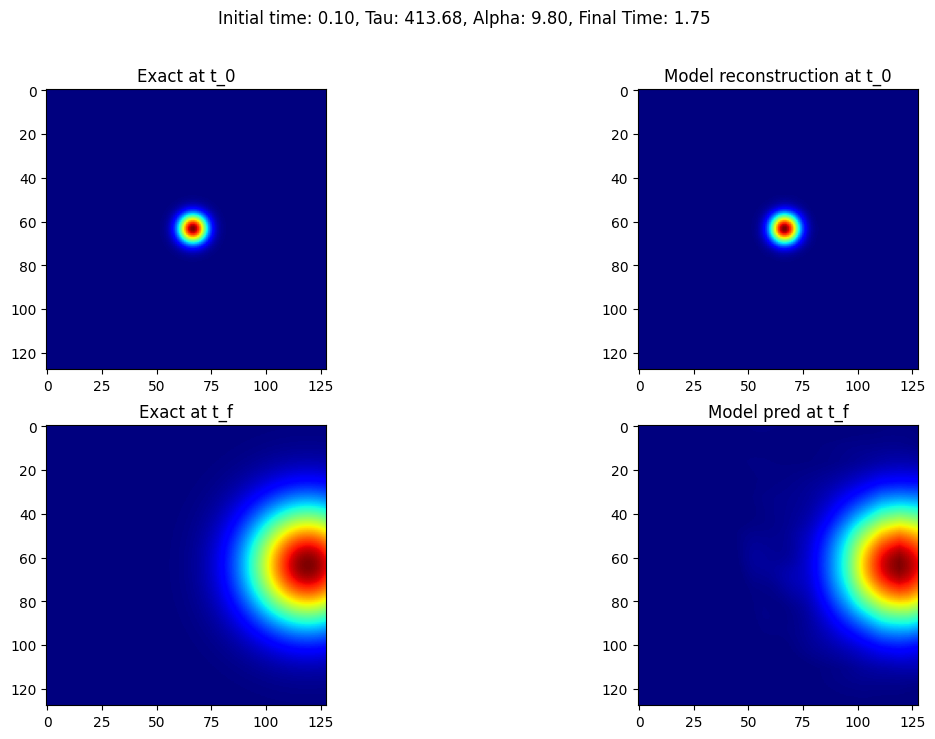

In [17]:
t_0 = 0.1 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_RE = np.random.uniform(*alpha_interval_split.extrapolation_right)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_RE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at t_0 + tau_LE*dt and alpha_LE
x_exact_tf = exact_solution(alpha_RE, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
x_hat, x_hat_tau, _, _, _, _  = model(x_in, tau_in, alpha_in)

# Plotting:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1)
plt.imshow(x_exact_t0, cmap = "jet")
plt.title("Exact at t_0")

plt.subplot(2, 2, 2)
plt.imshow(x_hat.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model reconstruction at t_0")

plt.subplot(2, 2, 3)
plt.imshow(x_exact_tf, cmap = "jet")
plt.title("Exact at t_f")

plt.subplot(2, 2, 4)
plt.imshow(x_hat_tau.cpu().detach().numpy().squeeze(), cmap = "jet")
plt.title("Model pred at t_f")

plt.suptitle(f"Initial time: {t_0:.2f}, Tau: {tau_RE:.2f}, Alpha: {alpha_RE:.2f}, Final Time: {t_0 + tau_RE*dt:.2f}");

## Arbitary take alpha from the interp region and exterp and arbitary \$t_0$, give three tau to it and observe how they comapre with exact solutions -

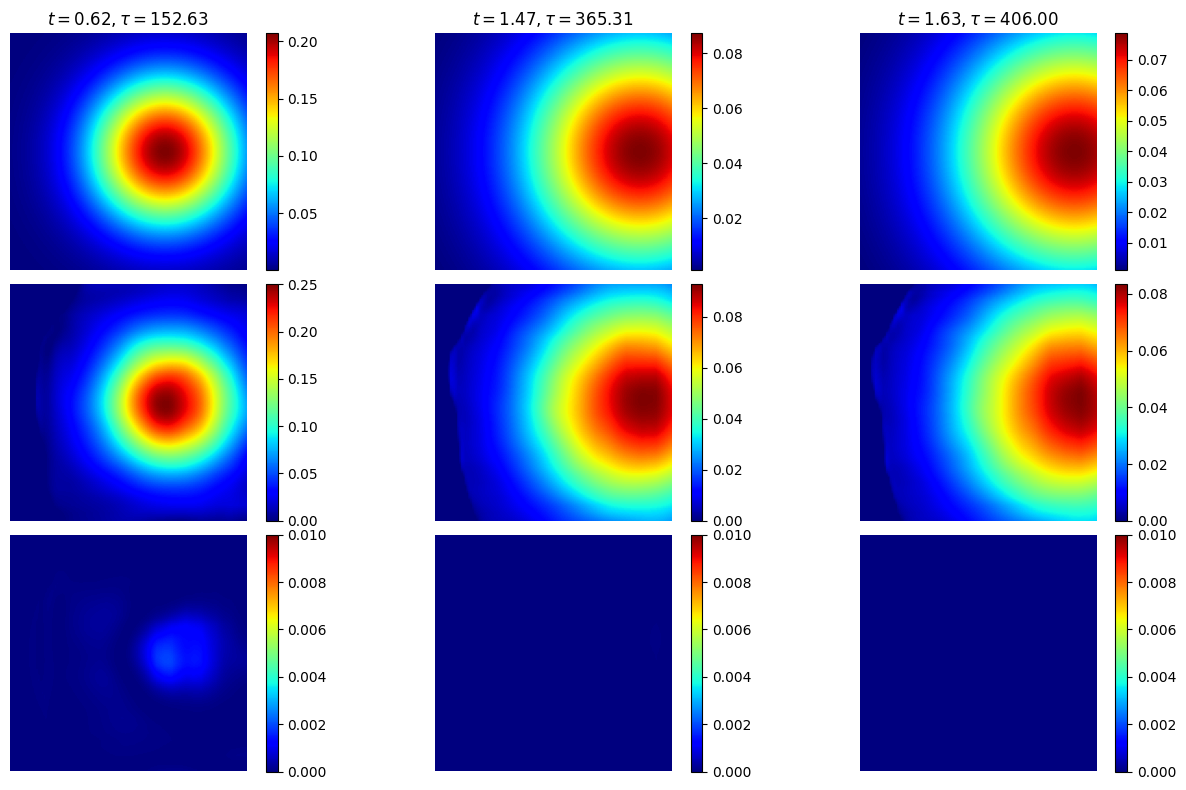

In [18]:
t_0 = 0.01 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_Interp = np.random.uniform(*alpha_interval_split.extrapolation_left)

# All three taus from val region!
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_Interp, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at three different values of tau and alpha_Interp
x_exact_tf_le = exact_solution(alpha_Interp, t_0+tau_LE*dt)
x_exact_tf_interp = exact_solution(alpha_Interp, t_0+tau_Interp*dt)
x_exact_tf_re = exact_solution(alpha_Interp, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()

tau_in_le = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_interp = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_re = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
_, x_hat_tau_le, _, _, _, _  = model(x_in, tau_in_le, alpha_in) #propogate the solution x_in by tau_in_le steps under alpha_in params!
_, x_hat_tau_interp, _, _, _, _  = model(x_in, tau_in_interp, alpha_in) #propogate the solution x_in by tau_in_interp steps under alpha_in params!
_, x_hat_tau_re, _, _, _, _  = model(x_in, tau_in_re, alpha_in) #propogate the solution x_in by tau_in_re steps under alpha_in params!


plt.figure(figsize=(14, 8))  # Adjust figure size to fit plots better

# ----------------- Exact solutions: --------------
plt.subplot(3, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# ---------------- Model Predictions: ----------------
plt.subplot(3, 3, 4)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 5)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 6)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# --------------- MSE Errors ---------------------------
plt.subplot(3, 3, 7)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 8)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 9)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)

plt.show()

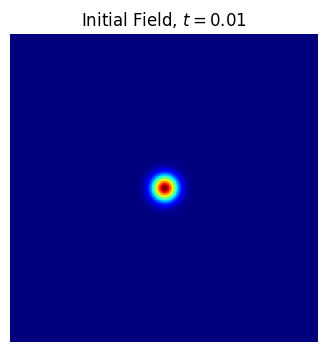

In [19]:
plt.figure(figsize = (4, 4))

# ---- Original initial field ---- 
plt.imshow(x_exact_t0, cmap = "jet")
plt.title(rf"Initial Field, $t = {t_0:.2f}$")
plt.savefig("initial_field_re_interp.png", bbox_inches="tight", pad_inches=0)
plt.axis(False)
plt.show()

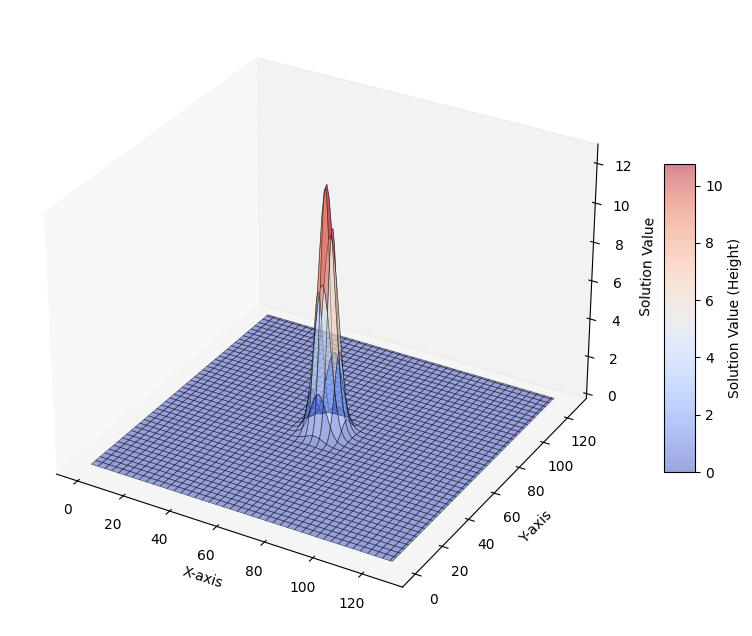

In [20]:
# Create a mesh grid for the surface
x, y = np.meshgrid(np.arange(x_exact_t0.shape[1]), np.arange(x_exact_t0.shape[0]))

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with mesh
surface = ax.plot_surface(
    x, y, x_exact_t0, cmap="coolwarm", alpha=0.5, edgecolor="k", linewidth=0.5, antialiased=True
)

# Add color bar to represent the height (solution values)
cbar = fig.colorbar(surface, ax=ax, shrink=0.4, aspect=10)
cbar.set_label("Solution Value (Height)")

# Add labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Solution Value")

# Remove gridlines from x, y, z planes
ax.grid(False)

# Show the plot
plt.tight_layout()

plt.savefig("3d_plot_interp.png", bbox_inches="tight", pad_inches=0)
plt.show()

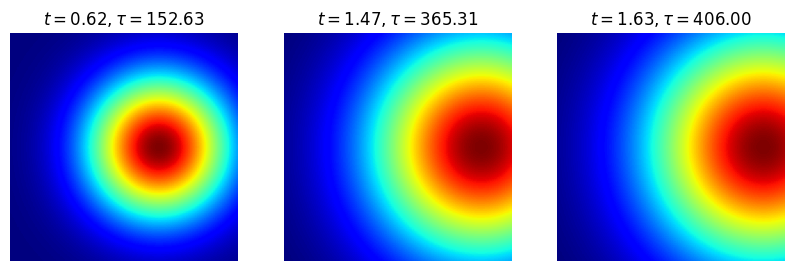

In [21]:
plt.figure(figsize=(10, 5))

# ----------------- Exact solutions: --------------
plt.subplot(1, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
#plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
#plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)

plt.savefig("Exact_Re_interp", bbox_inches="tight", pad_inches=0)
plt.show()
#plt.colorbar(fraction=0.046, pad=0.04)

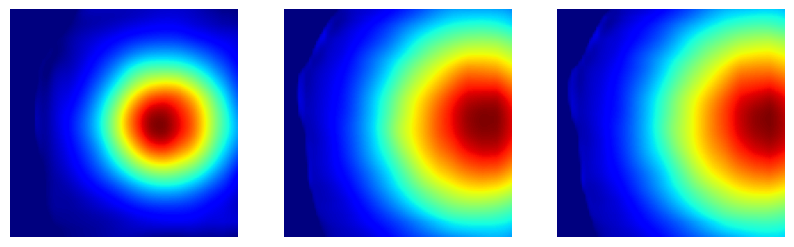

In [22]:
# ---------------- Model Predictions: ----------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
#plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
#plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)

plt.savefig("Prediction_Re_interp", bbox_inches="tight", pad_inches=0)
#plt.colorbar(fraction=0.046, pad=0.04)"

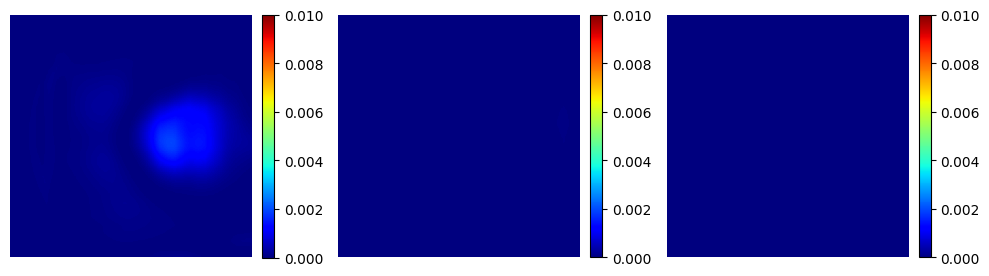

In [23]:
# --------------- MSE Errors ---------------------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)
plt.savefig("MSE_Interp", bbox_inches="tight", pad_inches=0)
plt.show()

# Take alpha in the Exterpolation region and all three values of tau 

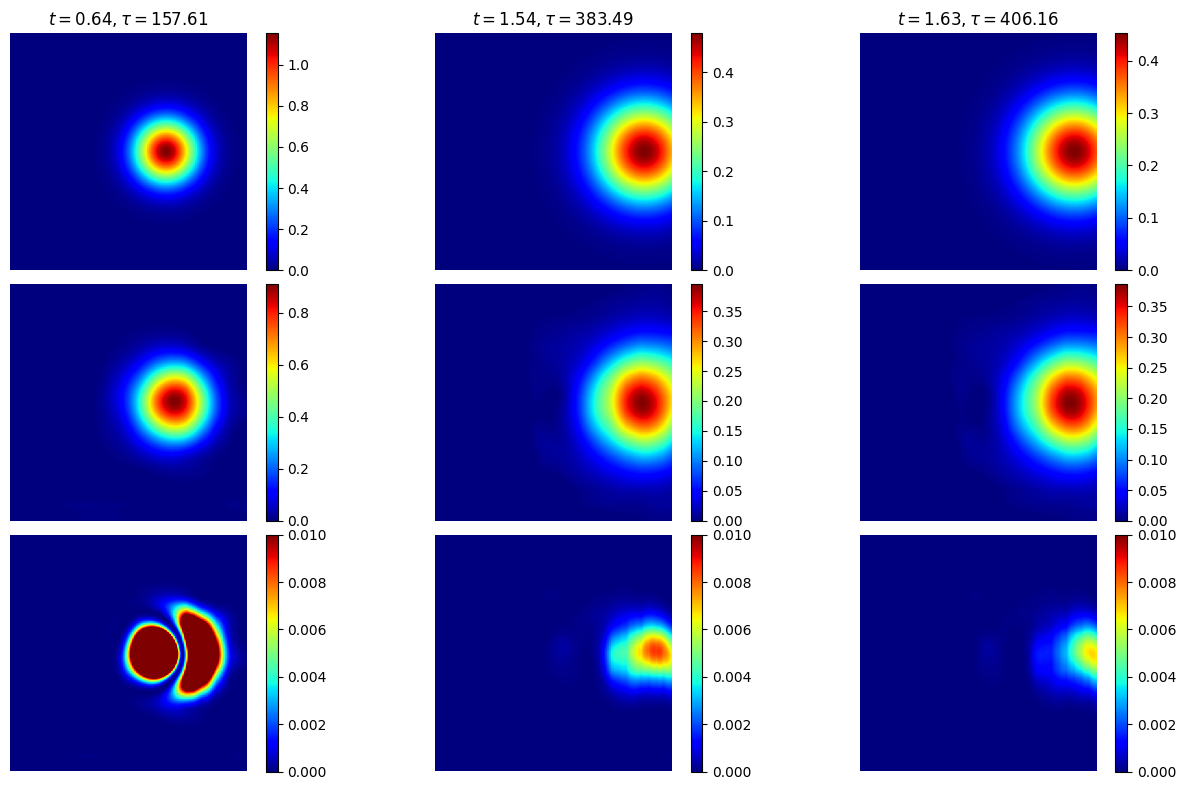

In [24]:
t_0 = 0.01 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_RE = np.random.uniform(*alpha_interval_split.extrapolation_right)

# All three taus from val region!
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_RE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at three different values of tau and alpha_Interp
x_exact_tf_le = exact_solution(alpha_RE, t_0+tau_LE*dt)
x_exact_tf_interp = exact_solution(alpha_RE, t_0+tau_Interp*dt)
x_exact_tf_re = exact_solution(alpha_RE, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_re = torch.tensor(np.expand_dims(alpha_RE, axis = 0), dtype = torch.float32)[None, :].cuda()

tau_in_le = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_interp = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_re = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
_, x_hat_tau_le, _, _, _, _  = model(x_in, tau_in_le, alpha_re) #propogate the solution x_in by tau_in_le steps under alpha_in params!
_, x_hat_tau_interp, _, _, _, _  = model(x_in, tau_in_interp, alpha_re) #propogate the solution x_in by tau_in_interp steps under alpha_in params!
_, x_hat_tau_re, _, _, _, _  = model(x_in, tau_in_re, alpha_re) #propogate the solution x_in by tau_in_re steps under alpha_in params!


plt.figure(figsize=(14, 8))  # Adjust figure size to fit plots better

# ----------------- Exact solutions: --------------
plt.subplot(3, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# ---------------- Model Predictions: ----------------
plt.subplot(3, 3, 4)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 5)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 6)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# --------------- MSE Errors ---------------------------
plt.subplot(3, 3, 7)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 8)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 9)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)

plt.show()

# 3 Axis Plot 

## LE Re

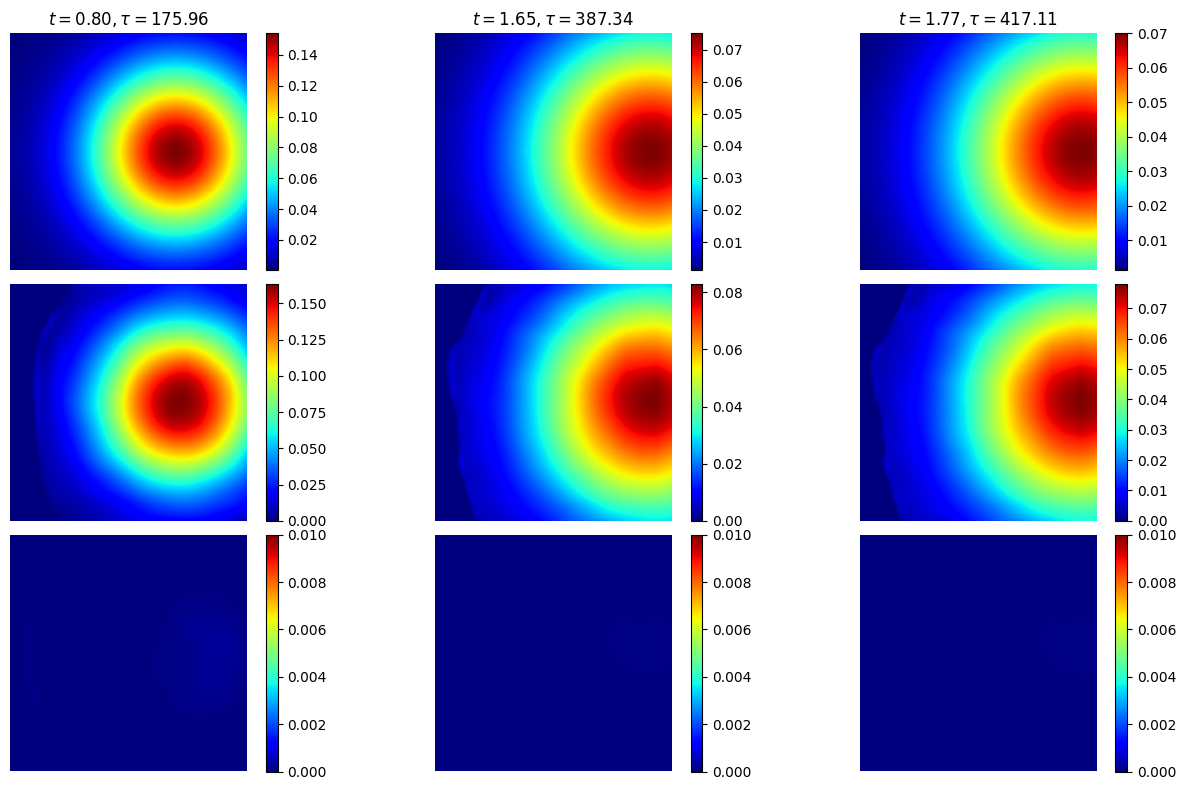

In [95]:
t_0 = 0.10 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_LE = np.random.uniform(*alpha_interval_split.extrapolation_left)

# All three taus from val region!
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_LE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at three different values of tau and alpha_Interp
x_exact_tf_le = exact_solution(alpha_LE, t_0+tau_LE*dt)
x_exact_tf_interp = exact_solution(alpha_LE, t_0+tau_Interp*dt)
x_exact_tf_re = exact_solution(alpha_LE, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_LE, axis = 0), dtype = torch.float32)[None, :].cuda()

tau_in_le = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_interp = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_re = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
_, x_hat_tau_le, _, _, _, _  = model(x_in, tau_in_le, alpha_in) #propogate the solution x_in by tau_in_le steps under alpha_in params!
_, x_hat_tau_interp, _, _, _, _  = model(x_in, tau_in_interp, alpha_in) #propogate the solution x_in by tau_in_interp steps under alpha_in params!
_, x_hat_tau_re, _, _, _, _  = model(x_in, tau_in_re, alpha_in) #propogate the solution x_in by tau_in_re steps under alpha_in params!


plt.figure(figsize=(14, 8))  # Adjust figure size to fit plots better

# ----------------- Exact solutions: --------------
plt.subplot(3, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# ---------------- Model Predictions: ----------------
plt.subplot(3, 3, 4)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 5)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 6)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# --------------- MSE Errors ---------------------------
plt.subplot(3, 3, 7)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 8)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 9)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)

plt.show()

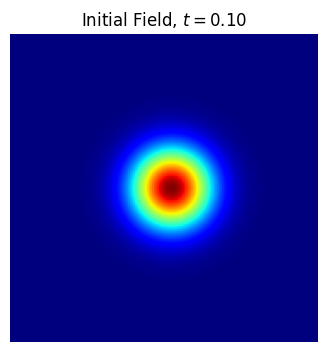

In [96]:
plt.figure(figsize = (4, 4))

# ---- Original initial field ---- 
plt.imshow(x_exact_t0, cmap = "jet")
plt.title(rf"Initial Field, $t = {t_0:.2f}$")
plt.savefig("initial_field_re_LE.png", bbox_inches="tight", pad_inches=0)
plt.axis(False)
plt.show()

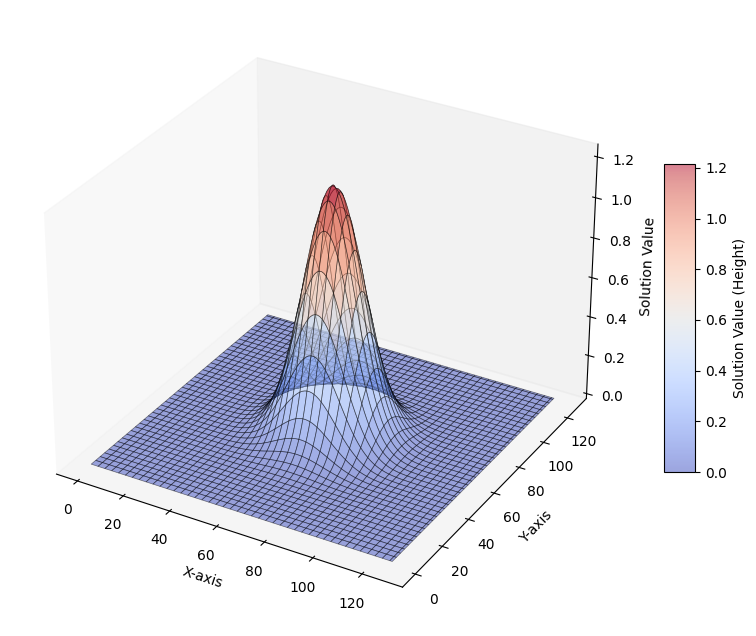

In [97]:
# Create a mesh grid for the surface
x, y = np.meshgrid(np.arange(x_exact_t0.shape[1]), np.arange(x_exact_t0.shape[0]))

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with mesh
surface = ax.plot_surface(
    x, y, x_exact_t0, cmap="coolwarm", alpha=0.5, edgecolor="k", linewidth=0.5, antialiased=True
)

# Add color bar to represent the height (solution values)
cbar = fig.colorbar(surface, ax=ax, shrink=0.4, aspect=10)
cbar.set_label("Solution Value (Height)")

# Add labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Solution Value")

# Remove gridlines from x, y, z planes
ax.grid(False)

# Show the plot
plt.tight_layout()

plt.savefig("3d_plot_re_LE.png", bbox_inches="tight", pad_inches=0)
plt.show()

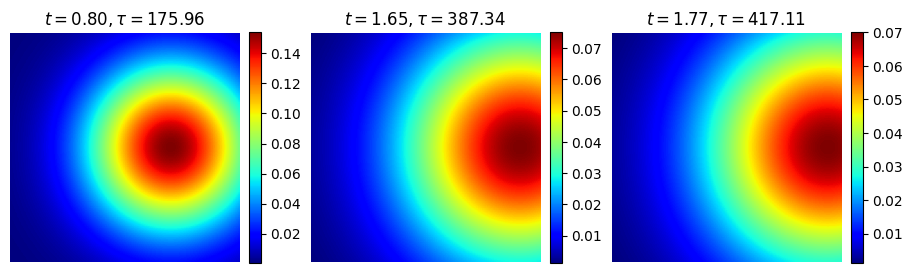

In [100]:
plt.figure(figsize=(11, 6))

# ----------------- Exact solutions: --------------
plt.subplot(1, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig("Exact_Re_LE", bbox_inches="tight", pad_inches=0)
plt.show()

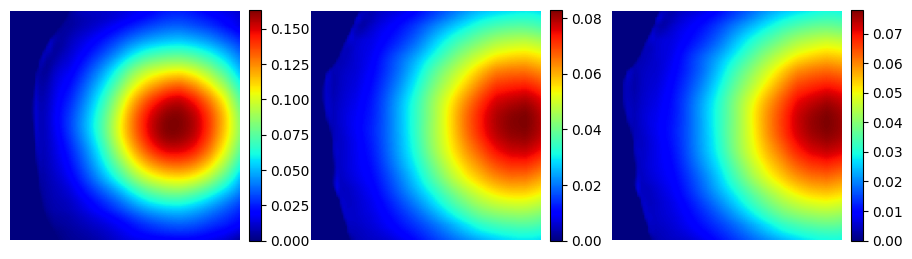

In [101]:
# ---------------- Model Predictions: ----------------
plt.figure(figsize=(11, 6))

plt.subplot(1, 3, 1)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis(False)

plt.savefig("Prediction_Re_LE", bbox_inches="tight", pad_inches=0)

## Interp Re

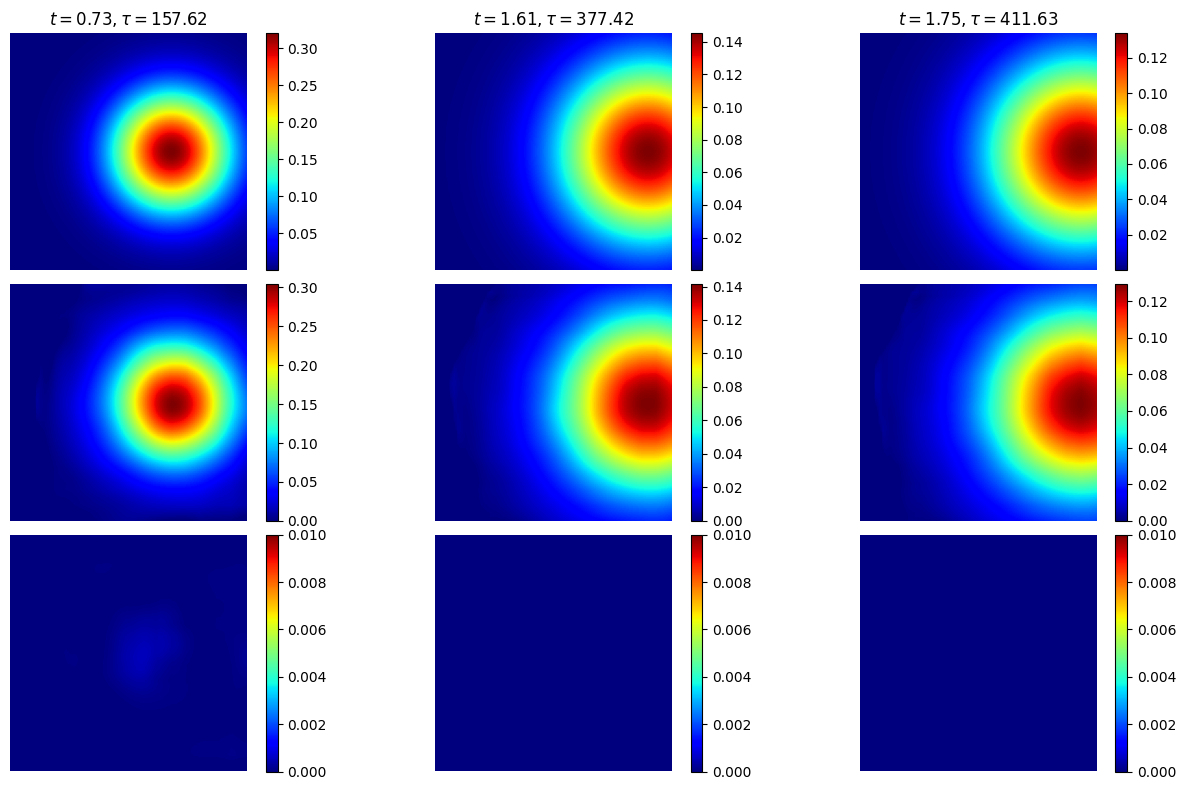

In [113]:
t_0 = 0.10 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_Interp = np.random.uniform(*alpha_interval_split.interpolation)

# All three taus from val region!
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_Interp, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at three different values of tau and alpha_Interp
x_exact_tf_le = exact_solution(alpha_Interp, t_0+tau_LE*dt)
x_exact_tf_interp = exact_solution(alpha_Interp, t_0+tau_Interp*dt)
x_exact_tf_re = exact_solution(alpha_Interp, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()

tau_in_le = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_interp = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_re = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
_, x_hat_tau_le, _, _, _, _  = model(x_in, tau_in_le, alpha_in) #propogate the solution x_in by tau_in_le steps under alpha_in params!
_, x_hat_tau_interp, _, _, _, _  = model(x_in, tau_in_interp, alpha_in) #propogate the solution x_in by tau_in_interp steps under alpha_in params!
_, x_hat_tau_re, _, _, _, _  = model(x_in, tau_in_re, alpha_in) #propogate the solution x_in by tau_in_re steps under alpha_in params!


plt.figure(figsize=(14, 8))  # Adjust figure size to fit plots better

# ----------------- Exact solutions: --------------
plt.subplot(3, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# ---------------- Model Predictions: ----------------
plt.subplot(3, 3, 4)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 5)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 6)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# --------------- MSE Errors ---------------------------
plt.subplot(3, 3, 7)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 8)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 9)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)

plt.show()

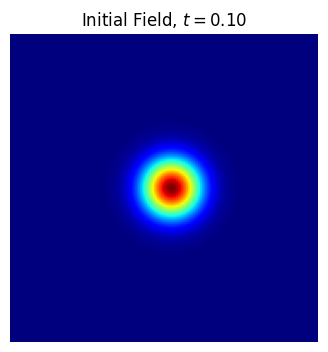

In [114]:
plt.figure(figsize = (4, 4))

# ---- Original initial field ---- 
plt.imshow(x_exact_t0, cmap = "jet")
plt.title(rf"Initial Field, $t = {t_0:.2f}$")
plt.savefig("initial_field_re_Interp.png", bbox_inches="tight", pad_inches=0)
plt.axis(False)
plt.show()

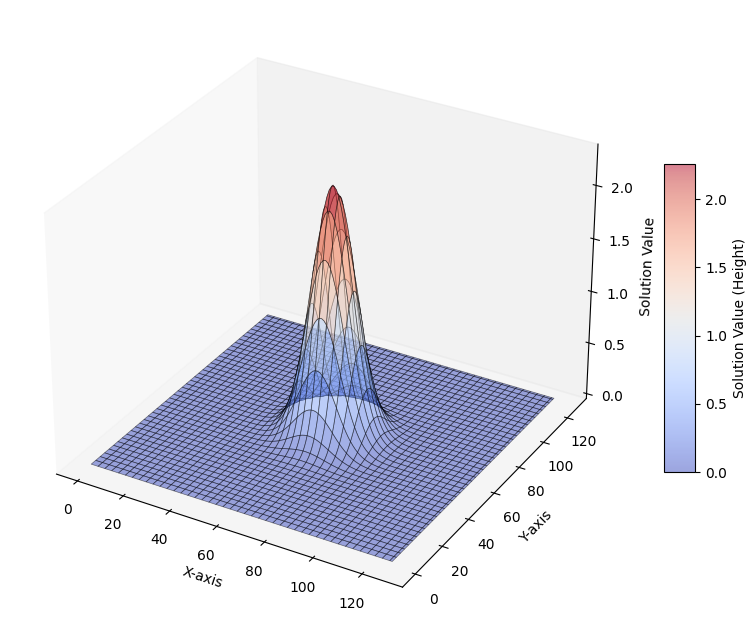

In [115]:
# Create a mesh grid for the surface
x, y = np.meshgrid(np.arange(x_exact_t0.shape[1]), np.arange(x_exact_t0.shape[0]))

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with mesh
surface = ax.plot_surface(
    x, y, x_exact_t0, cmap="coolwarm", alpha=0.5, edgecolor="k", linewidth=0.5, antialiased=True
)

# Add color bar to represent the height (solution values)
cbar = fig.colorbar(surface, ax=ax, shrink=0.4, aspect=10)
cbar.set_label("Solution Value (Height)")

# Add labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Solution Value")

# Remove gridlines from x, y, z planes
ax.grid(False)

# Show the plot
plt.tight_layout()

plt.savefig("3d_plot_re_Interp.png", bbox_inches="tight", pad_inches=0)
plt.show()

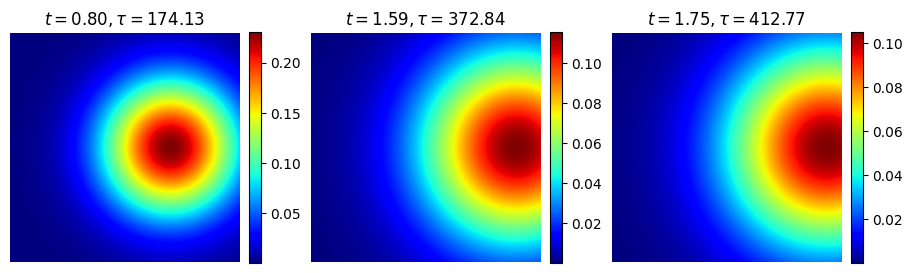

In [105]:
plt.figure(figsize=(11, 6))

# ----------------- Exact solutions: --------------
plt.subplot(1, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig("Exact_Re_Interp", bbox_inches="tight", pad_inches=0)
plt.show()

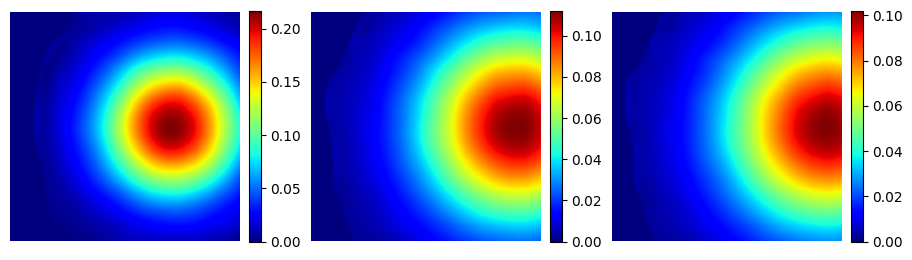

In [106]:
# ---------------- Model Predictions: ----------------
plt.figure(figsize=(11, 6))

plt.subplot(1, 3, 1)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis(False)

plt.savefig("Prediction_Re_Interp", bbox_inches="tight", pad_inches=0)

## RE Re

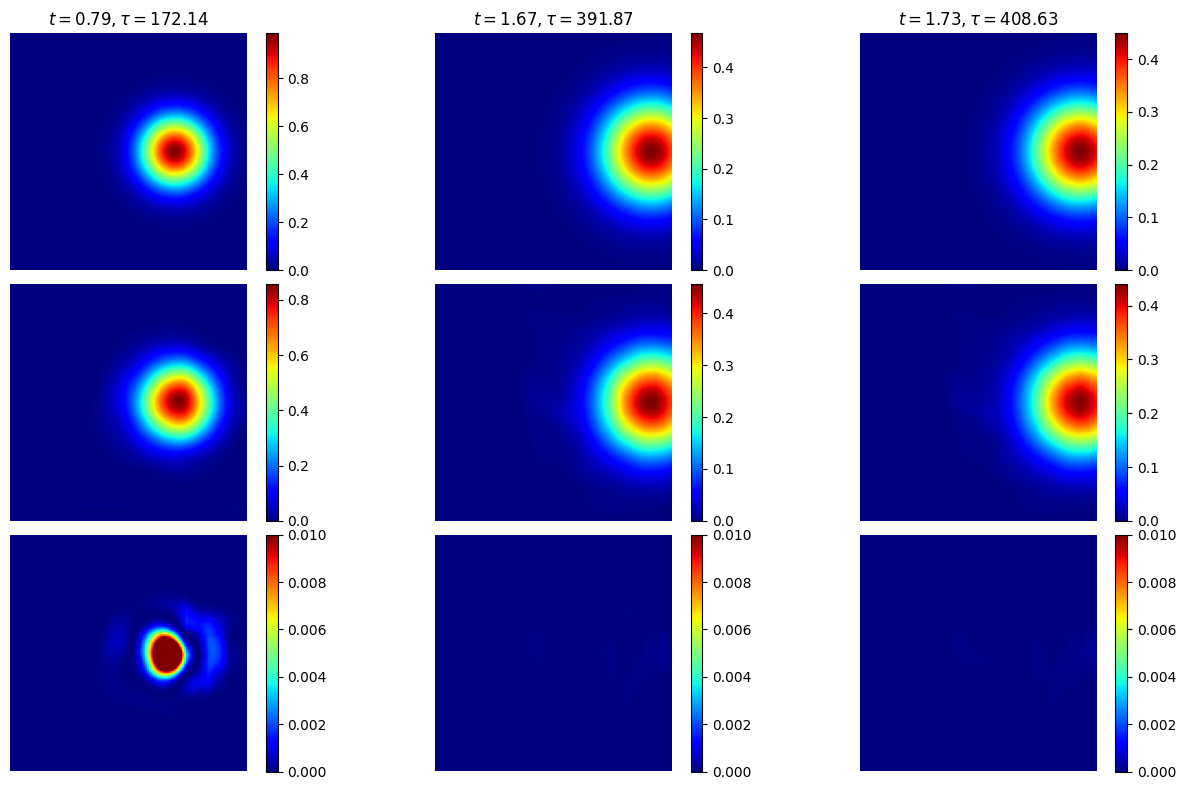

In [107]:
t_0 = 0.10 # Initialize with some time:

# Define alpha and tau in the LE regions;
alpha_RE = np.random.uniform(*alpha_interval_split.extrapolation_right)

# All three taus from val region!
tau_LE = np.random.uniform(*tau_interval_split.extrapolation_left)
tau_Interp = np.random.uniform(*tau_interval_split.interpolation)
tau_RE = np.random.uniform(*tau_interval_split.extrapolation_right)

# Get the exact solution at t_0 and alpha_LE
x_exact_t0 = exact_solution(alpha_RE, t_0)
#print(x_exact_t0.shape)

# Now get the exact solution at three different values of tau and alpha_Interp
x_exact_tf_le = exact_solution(alpha_RE, t_0+tau_LE*dt)
x_exact_tf_interp = exact_solution(alpha_RE, t_0+tau_Interp*dt)
x_exact_tf_re = exact_solution(alpha_RE, t_0+tau_RE*dt)
#print(x_exact_tf.shape)

# Let us do the model reconstruction of x_exact_tf and predition tau_LE steps from this:

# Expanding the dimesions and putting on cuda
x_in = torch.tensor(x_exact_t0, dtype = torch.float32)[None, None, :, :].cuda()
alpha_in = torch.tensor(np.expand_dims(alpha_RE, axis = 0), dtype = torch.float32)[None, :].cuda()

tau_in_le = torch.tensor(np.expand_dims(tau_LE, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_interp = torch.tensor(np.expand_dims(tau_Interp, axis = 0), dtype = torch.float32)[None, :].cuda()
tau_in_re = torch.tensor(np.expand_dims(tau_RE, axis = 0), dtype = torch.float32)[None, :].cuda()
#print(x_in.shape, alpha_in.shape, tau_in.shape)

# Inputting in the Model:
_, x_hat_tau_le, _, _, _, _  = model(x_in, tau_in_le, alpha_in) #propogate the solution x_in by tau_in_le steps under alpha_in params!
_, x_hat_tau_interp, _, _, _, _  = model(x_in, tau_in_interp, alpha_in) #propogate the solution x_in by tau_in_interp steps under alpha_in params!
_, x_hat_tau_re, _, _, _, _  = model(x_in, tau_in_re, alpha_in) #propogate the solution x_in by tau_in_re steps under alpha_in params!


plt.figure(figsize=(14, 8))  # Adjust figure size to fit plots better

# ----------------- Exact solutions: --------------
plt.subplot(3, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# ---------------- Model Predictions: ----------------
plt.subplot(3, 3, 4)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 5)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 6)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# --------------- MSE Errors ---------------------------
plt.subplot(3, 3, 7)
plt.imshow((x_exact_tf_le - x_hat_tau_le.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 8)
plt.imshow((x_exact_tf_interp - x_hat_tau_interp.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3, 3, 9)
plt.imshow((x_exact_tf_re - x_hat_tau_re.cpu().detach().numpy().squeeze())**2, cmap="jet", vmin=0, vmax=1e-2)
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

# Reduce vertical spacing between rows
plt.tight_layout(h_pad=0.0)

plt.show()

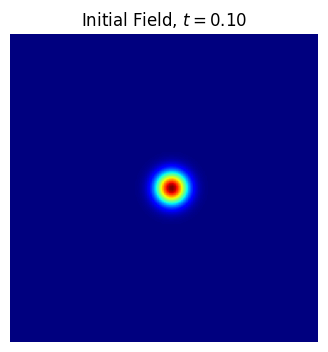

In [108]:
plt.figure(figsize = (4, 4))

# ---- Original initial field ---- 
plt.imshow(x_exact_t0, cmap = "jet")
plt.title(rf"Initial Field, $t = {t_0:.2f}$")
plt.savefig("initial_field_re_RE.png", bbox_inches="tight", pad_inches=0)
plt.axis(False)
plt.show()

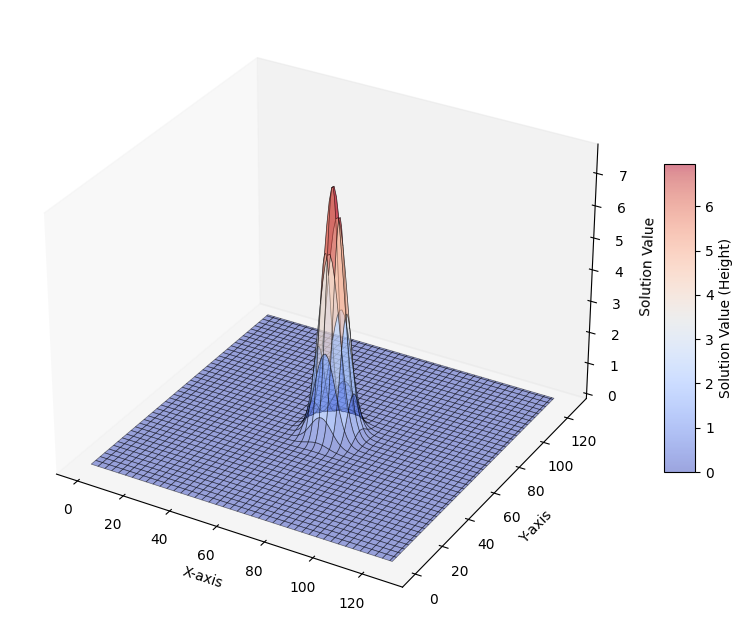

In [110]:
# Create a mesh grid for the surface
x, y = np.meshgrid(np.arange(x_exact_t0.shape[1]), np.arange(x_exact_t0.shape[0]))

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with mesh
surface = ax.plot_surface(
    x, y, x_exact_t0, cmap="coolwarm", alpha=0.5, edgecolor="k", linewidth=0.5, antialiased=True
)

# Add color bar to represent the height (solution values)
cbar = fig.colorbar(surface, ax=ax, shrink=0.4, aspect=10)
cbar.set_label("Solution Value (Height)")

# Add labels and title
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Solution Value")

# Remove gridlines from x, y, z planes
ax.grid(False)

# Show the plot
plt.tight_layout()

plt.savefig("3d_plot_re_RE.png", bbox_inches="tight", pad_inches=0)
plt.show()

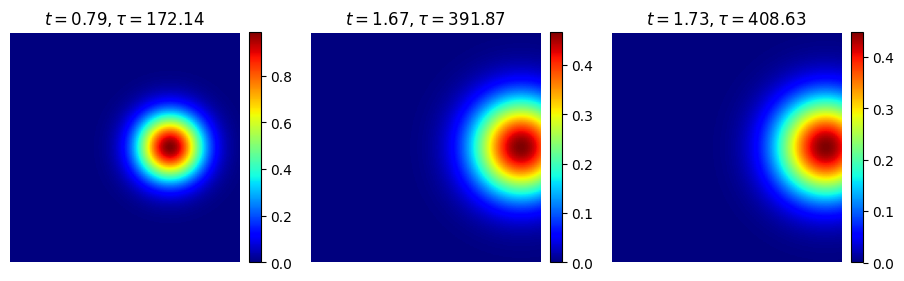

In [111]:
plt.figure(figsize=(11, 6))

# ----------------- Exact solutions: --------------
plt.subplot(1, 3, 1)
plt.imshow(x_exact_tf_le, cmap="jet")
plt.title(rf"$t = {t_0 + tau_LE*dt:.2f}, \tau = {tau_LE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_exact_tf_interp, cmap="jet")
plt.title(rf"$t = {t_0 + tau_Interp*dt:.2f}, \tau = {tau_Interp:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_exact_tf_re, cmap="jet")
plt.title(rf"$t = {t_0 + tau_RE*dt:.2f}, \tau = {tau_RE:.2f}$")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig("Exact_Re_RE", bbox_inches="tight", pad_inches=0)
plt.show()

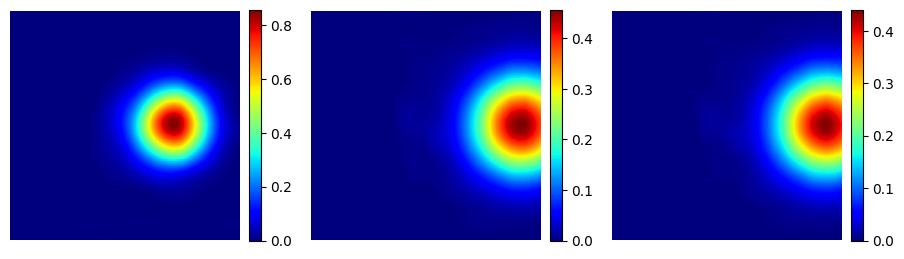

In [112]:
# ---------------- Model Predictions: ----------------
plt.figure(figsize=(11, 6))

plt.subplot(1, 3, 1)
plt.imshow(x_hat_tau_le.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(x_hat_tau_interp.cpu().detach().numpy().squeeze(), cmap="jet")
plt.axis(False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow(x_hat_tau_re.cpu().detach().numpy().squeeze(), cmap="jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis(False)

plt.savefig("Prediction_Re_RE", bbox_inches="tight", pad_inches=0)